### Checking autoencoder

Notebook to test autoencoder.

All you need to input is an example data file and a trained autoencoder model (plus make sure number of features, latent dimensions and batch size are correct). It then encodes your data and decodes it, generating a UMAP to compare raw and decoded data.

### Loading modules

In [1]:
import numpy as np
import sys
import torch
import scanpy as sc
import anndata as ad
from torch.utils.data import DataLoader, TensorDataset

sys.path.append("/dtu/blackhole/1e/213566/Isoflow")
from autoencoder_utils import NB_Autoencoder 
from autoencoder_utils import sample_nb

### Loading paths

In [2]:
#trained autoencoder model
model_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
model_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
#training data to check on
train_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train.h5ad"
train_path = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/pbmc3k_train.h5ad"



### Loading model

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters 
num_features = 8573  # number of genes/features
latent_dim = 50
batch_size = 512

# Instantiate the model
model = NB_Autoencoder(num_features=num_features, latent_dim=latent_dim)
model.to(device)

# Load trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # set to evaluation mode

NB_Autoencoder(
  (hidden_encoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8573, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): Dropout(p=0.1, inplace=False)
      )
      (1): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (latent_layer): Linear(in_features=256, out_features=50, bias=True)
  (decoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): Dropout(p=0.1, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
        (3): Dro

### Encode

In [4]:
adata_train = ad.read_h5ad(train_path)
X = adata_train.layers["X_counts"]
adata_train.obs["dataset"] = "train"
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)


In [5]:
# --- Encode cells ---

# Dataset + DataLoader
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.eval()
all_z = []
with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=batch_size):
        x_batch = batch[0].to(device)
        z = model(x_batch)["z"].cpu().numpy()
        all_z.append(z)

latent = np.concatenate(all_z, axis=0)

# Save to AnnData
adata_train.obsm["X_latent"] = latent


In [6]:
#print(adata_train.obsm["X_latent"].shape)
#print(adata_train.obsm["X_latent"])
#print(all_z)

### Decode

In [7]:
#Decode generated data
z = torch.tensor(latent, dtype=torch.float32, device=device)


In [8]:
with torch.no_grad():  # no gradient needed for inference
    decoded = model.decode(z)

mu = decoded["mu"]        # expected counts
theta = decoded["theta"]  # dispersion
print(mu.shape, theta.shape)


torch.Size([2110, 8573]) torch.Size([2110, 8573])


In [9]:
counts = sample_nb(mu, theta)

# Create AnnData object
adata_gen = ad.AnnData(X=counts.cpu().numpy())

# Assign gene names from test dataset
adata_gen.var_names = adata_train.var_names.copy()

# All generated cells are B cells
adata_gen.obs["dataset"] = "decoded"

sc.pp.filter_genes(adata_gen, min_cells=20)


### Comparing

/tmp/ipykernel_2249457/1532403212.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  merged_adata = adata_train.concatenate(adata_gen, batch_key="batch", batch_categories=["train", "decoded"])
/appl9/python/3.12.9/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


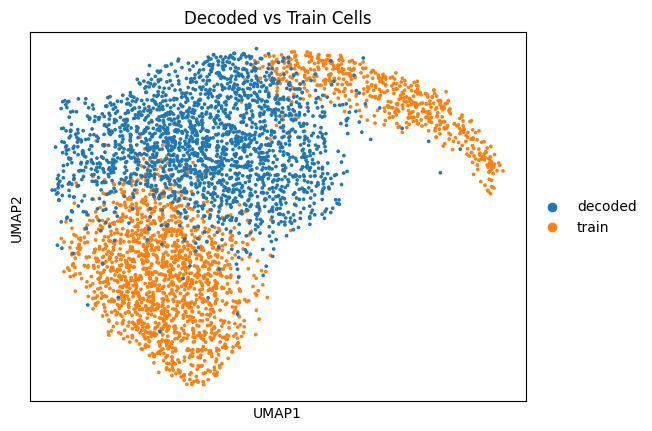

In [10]:
merged_adata = adata_train.concatenate(adata_gen, batch_key="batch", batch_categories=["train", "decoded"])

sc.pp.scale(merged_adata)

# PCA and neighbors
sc.tl.pca(merged_adata, svd_solver='arpack')
sc.pp.neighbors(merged_adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(merged_adata)

# Plot
sc.pl.umap(merged_adata, color="dataset", title="Decoded vs Train Cells")
